In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '0'

In [ ]:
#Resources used:
#https://vtiya.medium.com/the-difference-between-bert-uncased-and-cased-ec25e632b426#:~:text=%E2%80%9CUncased%E2%80%9D%3A%20Characters%20which%20are,difference%20between%20english%20and%20English.
#https://huggingface.co/google-bert/bert-base-cased
#https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/
#https://www.tensorflow.org/text/tutorials/classify_text_with_bert
#https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html
#https://medium.com/@shaikhrayyan123/a-comprehensive-guide-to-understanding-bert-from-beginners-to-advanced-2379699e2b51
#https://medium.com/@heyamit10/fine-tuning-bert-for-classification-a-practical-guide-b8c1c56f252c
#https://yashuseth.wordpress.com/2019/06/12/bert-explained-faqs-understand-bert-working/
#https://huggingface.co/docs/transformers/en/model_doc/bert#transformers.BertModel
#https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/


#For building model
#https://www.sabrepc.com/blog/Deep-Learning-and-AI/text-classification-with-bert?srsltid=AfmBOopz30a90TLa1G6JClyLTGzmcG9l3Lmnd2irr6tG9qp576IHSG7g

#Distilbert
#https://towardsdatascience.com/feature-extraction-with-bert-for-text-classification-533dde44dc2f/

In [ ]:
#Import necessary modules
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertConfig
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import re
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset

# Dataset 1

In [ ]:
import kagglehub
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("bayes2003/emails-for-spam-or-ham-classification-trec-2005")

print("Path to dataset files:", path)


# Define dataset path
dataset_folder = path  # This is the downloaded dataset folder

# List files in the dataset folder
files = os.listdir(dataset_folder)
print("Dataset files:", files)

# Load a CSV file into pandas
csv_file = os.path.join(dataset_folder, files[1]) # Replace with actual file name
df = pd.read_csv(csv_file, encoding='ISO-8859-1')


# utilizing 2 differnet datasets
df_1 = df.copy()
# cleaning df_1
# Rename relevant columns

df_1 = df_1[['label', 'text']]
df_1.columns = ['label', 'text']


# Display first few rows
df_1

# Remove multiple spaces
df_1['text'] = df_1['text'].str.strip()
df_1['text'] = df_1['text'].str.replace(r'\s+', ' ', regex=True)
# fix encoding issues since there are random symbols such as: â, Âº, etc.
df_1['text'] = df_1['text'].str.encode('ascii', 'ignore').str.decode('utf-8')

# removing number placeholders (&lt;#&gt)
df_1['text'] = df_1['text'].str.replace(r'&lt;#&gt;', '[NUMBER]', regex=True)

# removing URL placeholders (&lt;URL&gt;)
df_1['text'] = df_1['text'].str.replace(r'&lt;URL&gt;', '[URL]', regex=True)

# removing decimal placeholders (&lt;DECIMAL&gt;)
df_1['text'] = df_1['text'].str.replace(r'&lt;DECIMAL&gt;', '[DECIMAL]', regex=True)

# removing time placeholders (&lt;TIME&gt;)
df_1['text'] = df_1['text'].str.replace(r'&lt;TIME&gt;', '[TIME]', regex=True)

# removing email placeholders (&lt;EMAIL&gt;)
df_1['text'] = df_1['text'].str.replace(r'&lt;EMAIL&gt;', '[EMAIL]', regex=True)

# Remove all occurrences of '&gt;' (greater-than sign encoding)
df_1['text'] = df_1['text'].str.replace(r'&gt;', '', regex=True)
df_1['text'] = '[EMAILBODY]'+ " " + df_1['text']
df_1['subject line'] = '[NOSUB]'
df_1['combined_text'] = df_1['subject line'] + " " + df_1['text']



Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\bayes2003\emails-for-spam-or-ham-classification-trec-2005\versions\1
Dataset files: ['email_origin.csv', 'email_text.csv', 'trec05p-1.tgz']


In [ ]:
df_1 = df_1.sample(n=5572,random_state=42).reset_index(drop=True)
df_1

,label,text,subject line,combined_text
0,0,[EMAILBODY] for rings escapenumber escapenumbe...,[NOSUB],[NOSUB] [EMAILBODY] for rings escapenumber esc...
1,1,[EMAILBODY] dear tracy it's the american airli...,[NOSUB],[NOSUB] [EMAILBODY] dear tracy it's the americ...
2,0,[EMAILBODY] at escapenumber escapenumber est i...,[NOSUB],[NOSUB] [EMAILBODY] at escapenumber escapenumb...
3,0,[EMAILBODY] isda press report december escapen...,[NOSUB],[NOSUB] [EMAILBODY] isda press report december...
4,0,[EMAILBODY] hello here's a copy of the blue mo...,[NOSUB],[NOSUB] [EMAILBODY] hello here's a copy of the...
...,...,...,...,...
5567,0,[EMAILBODY] hey michelle i forgot i wasn't goi...,[NOSUB],[NOSUB] [EMAILBODY] hey michelle i forgot i wa...
5568,0,[EMAILBODY] reservation status has changed to ...,[NOSUB],[NOSUB] [EMAILBODY] reservation status has cha...
5569,0,[EMAILBODY] the reuters kobra servers are expe...,[NOSUB],[NOSUB] [EMAILBODY] the reuters kobra servers ...
5570,1,[EMAILBODY] april escapenumber escapenumber es...,[NOSUB],[NOSUB] [EMAILBODY] april escapenumber escapen...


In [ ]:
print(df_1.iloc[0, 1])  # First row (0) and first column (0)

[EMAILBODY] for rings escapenumber escapenumber escapenumber and escapenumber all pjm i noticed that there is an inconsistency between escapenumber the term section which refers to central prevailing time and escapenumber the scheduling section which refers to eastern prevailing time working under the assumption that the term for pjm is supposed to refer to eastern prevailing time i changed the term section of ring h to ept to match the scheduling section i suggest we check with melissa murphy tomorrow to confirm the correct time zone for the term section of pjm so that we can make appropriate corrections either to ring h or to rings escapenumber escapenumber escapenumber and escapenumber steve


# Dataset 2

In [ ]:
import kagglehub
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("venky73/spam-mails-dataset")

print("Path to dataset files:", path)


# Define dataset path
dataset_folder = path  # This is the downloaded dataset folder

# List files in the dataset folder
files = os.listdir(dataset_folder)
print("Dataset files:", files)

# Load a CSV file into pandas
csv_file = os.path.join(dataset_folder, files[0]) # Replace with actual file name
df = pd.read_csv(csv_file, encoding='ISO-8859-1')
df_2 = df.copy()
df_2.drop_duplicates(subset=['text'], inplace=True)
df_2.reset_index(drop=True, inplace=True)

# Convert labels to binary (1 for spam, 0 for non-spam)
df_2['label'] = df_2['label'].map({'ham': 0, 'spam': 1})
df_2['subject line'] = df_2['text'].str.extract(r'^Subject:\s*(.*)', expand=False)
def remove_subject_line(text):
    return re.sub(r'^Subject:.*\n?', '', text, flags=re.IGNORECASE | re.MULTILINE)

df_2['text'] = df_2['text'].apply(remove_subject_line)

for i in ['text','subject line']:
    # Remove multiple spaces
    df_2[i] = df_2[i].str.strip()
    df_2[i] = df_2[i].str.replace(r'\s+', ' ', regex=True)
    # fix encoding issues since there are random symbols such as: â, Âº, etc.
    df_2[i] = df_2[i].str.encode('ascii', 'ignore').str.decode('utf-8')

    # removing number placeholders (&lt;#&gt)
    df_2[i] = df_2[i].str.replace(r'&lt;#&gt;', '[NUMBER]', regex=True)

    # removing URL placeholders (&lt;URL&gt;)
    df_2[i] = df_2[i].str.replace(r'&lt;URL&gt;', '[URL]', regex=True)

    # removing decimal placeholders (&lt;DECIMAL&gt;)
    df_2[i] = df_2[i].str.replace(r'&lt;DECIMAL&gt;', '[DECIMAL]', regex=True)

    # removing time placeholders (&lt;TIME&gt;)
    df_2[i] = df_2[i].str.replace(r'&lt;TIME&gt;', '[TIME]', regex=True)

    # removing email placeholders (&lt;EMAIL&gt;)
    df_2[i] = df_2[i].str.replace(r'&lt;EMAIL&gt;', '[EMAIL]', regex=True)

    # Remove all occurrences of '&gt;' (greater-than sign encoding)
    df_2[i] = df_2[i].str.replace(r'&gt;', '', regex=True)
#Remove redundant columns
df_2.drop(columns=['label_num'], inplace=True)
df_2.drop(columns=['Unnamed: 0'], inplace=True)
df_2['text'] = '[EMAILBODY]'+ " " + df_2['text']
df_2['subject line'] = '[SUB] ' " " + df_2['subject line']
df_2['combined_text'] = df_2['subject line'] + " " + df_2['text']
df_2

Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\venky73\spam-mails-dataset\versions\1
Dataset files: ['spam_ham_dataset.csv']


,label,text,subject line,combined_text
0,0,[EMAILBODY] this is a follow up to the note i ...,[SUB] enron methanol ; meter # : 988291,[SUB] enron methanol ; meter # : 988291 [EMAI...
1,0,[EMAILBODY] ( see attached file : hplnol 09 . ...,"[SUB] hpl nom for january 9 , 2001","[SUB] hpl nom for january 9 , 2001 [EMAILBODY..."
2,0,"[EMAILBODY] ho ho ho , we ' re around to that ...",[SUB] neon retreat,"[SUB] neon retreat [EMAILBODY] ho ho ho , we ..."
3,1,[EMAILBODY] abasements darer prudently fortuit...,"[SUB] photoshop , windows , office . cheap . ...","[SUB] photoshop , windows , office . cheap . ..."
4,0,[EMAILBODY] this deal is to book the teco pvr ...,[SUB] re : indian springs,[SUB] re : indian springs [EMAILBODY] this de...
...,...,...,...,...
4988,0,[EMAILBODY] 9868 please note the following for...,"[SUB] fw : crosstex energy , driscoll ranch #...","[SUB] fw : crosstex energy , driscoll ranch #..."
4989,0,[EMAILBODY] the transport volumes decreased fr...,[SUB] put the 10 on the ft,[SUB] put the 10 on the ft [EMAILBODY] the tr...
4990,0,[EMAILBODY] hpl can ' t take the extra 15 mmcf...,[SUB] 3 / 4 / 2000 and following noms,[SUB] 3 / 4 / 2000 and following noms [EMAILB...
4991,0,[EMAILBODY] attached are the worksheets for au...,[SUB] industrial worksheets for august 2000 a...,[SUB] industrial worksheets for august 2000 a...


# Combined Dataset


In [ ]:
combined_df = pd.concat([df_1, df_2], ignore_index=True)
combined_df

,label,text,subject line,combined_text
0,0,[EMAILBODY] for rings escapenumber escapenumbe...,[NOSUB],[NOSUB] [EMAILBODY] for rings escapenumber esc...
1,1,[EMAILBODY] dear tracy it's the american airli...,[NOSUB],[NOSUB] [EMAILBODY] dear tracy it's the americ...
2,0,[EMAILBODY] at escapenumber escapenumber est i...,[NOSUB],[NOSUB] [EMAILBODY] at escapenumber escapenumb...
3,0,[EMAILBODY] isda press report december escapen...,[NOSUB],[NOSUB] [EMAILBODY] isda press report december...
4,0,[EMAILBODY] hello here's a copy of the blue mo...,[NOSUB],[NOSUB] [EMAILBODY] hello here's a copy of the...
...,...,...,...,...
10560,0,[EMAILBODY] 9868 please note the following for...,"[SUB] fw : crosstex energy , driscoll ranch #...","[SUB] fw : crosstex energy , driscoll ranch #..."
10561,0,[EMAILBODY] the transport volumes decreased fr...,[SUB] put the 10 on the ft,[SUB] put the 10 on the ft [EMAILBODY] the tr...
10562,0,[EMAILBODY] hpl can ' t take the extra 15 mmcf...,[SUB] 3 / 4 / 2000 and following noms,[SUB] 3 / 4 / 2000 and following noms [EMAILB...
10563,0,[EMAILBODY] attached are the worksheets for au...,[SUB] industrial worksheets for august 2000 a...,[SUB] industrial worksheets for august 2000 a...


# Defining the DistilBert and DistilBert Tokenizer


In [ ]:
#Defining BERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
bert = DistilBertModel.from_pretrained("distilbert-base-cased", num_labels=2)

# Useful Functions


In [ ]:
#Add special tokens
tokenizer.add_tokens(['[SUB]','[EMAILBODY]', '[NOSUB]'], special_tokens=True)

3

In [ ]:
#Function that finds maximum sequence length
def find_max_squence_length(texts):
  seq_len = [len(tokenizer.tokenize(i)) for i in texts]
  pd.Series(seq_len).hist(bins = 30)
  max_seq_len = max(seq_len)
  return(max_seq_len)

In [ ]:
#Function that finds maximum sequence length
def find_max_squence(texts, n):
  seq_len = [len(text) for text in texts if len(text) < n]
  pd.Series(seq_len).hist(bins = 30)
  return(len(seq_len))

In [ ]:
#Tokenization function
def tokenize_and_return_chunks_new(text, subject, label, chunk_length, num):
  chunksize = chunk_length
  chunks = [text[0:chunksize]]
  chunks.extend([subject + " " + ('[EMAILBODY]')+ " "  + text[i:i+chunk_length] for i in range(chunk_length, len(text), chunksize)])
  chunks_input =[]
  for i in chunks:
    embeddings = tokenizer(i, return_tensors='pt', max_length = chunksize, padding = 'max_length', truncation = True)
    chunks_input.append((embeddings, label))
  return chunks_input


In [ ]:
#Function that returns encoddings, labels, and the chunk index (nth chunk).
def get_embeddings_labels(texts, subject, labels, chunk_size):
  text_chunks_labels1 = []
  text_embeddings = []
  chunk_num = []
  num = 0
  for i in range(len(texts)):
    for j in tokenize_and_return_chunks_new(texts[i], subject[i], labels[i],chunk_size, num):
      text_embeddings.append(j[0])
      text_chunks_labels1.append(j[1])
      chunk_num.append(num)
    num+=1
  return (text_chunks_labels1,text_embeddings, chunk_num)

In [ ]:
#Balances trainingset with spam
def get_duplicate_spam_embeddings(embeddings, labels, chunknum):
  duplicate_embeddings = []
  duplicate_chunknum = []
  duplicate_labels = []
  index = 0
  while index < len(labels):
    if labels[index] == 1:
      duplicate_embeddings.append(embeddings[index])
      duplicate_chunknum.append(chunknum[index])
      duplicate_labels.append(torch.tensor([1]))
    index += 1

  return duplicate_embeddings, duplicate_chunknum, duplicate_labels

#Balances trainingset
def get_duplicate_nonspam_embeddings(embeddings, labels, chunknum):
  duplicate_embeddings = []
  duplicate_chunknum = []
  duplicate_labels = []
  index = 0
  while index < len(labels):
    if labels[index] == 0:
      duplicate_embeddings.append(embeddings[index])
      duplicate_chunknum.append(chunknum[index])
      duplicate_labels.append(torch.tensor([0]))
    index += 1

  return duplicate_embeddings, duplicate_chunknum, duplicate_labels



# Getting embeddings, labels, and chunk index for Dataset 1


In [ ]:
df_1copy = df_1.copy()
df_1copy

,label,text,subject line,combined_text
0,0,[EMAILBODY] for rings escapenumber escapenumbe...,[NOSUB],[NOSUB] [EMAILBODY] for rings escapenumber esc...
1,1,[EMAILBODY] dear tracy it's the american airli...,[NOSUB],[NOSUB] [EMAILBODY] dear tracy it's the americ...
2,0,[EMAILBODY] at escapenumber escapenumber est i...,[NOSUB],[NOSUB] [EMAILBODY] at escapenumber escapenumb...
3,0,[EMAILBODY] isda press report december escapen...,[NOSUB],[NOSUB] [EMAILBODY] isda press report december...
4,0,[EMAILBODY] hello here's a copy of the blue mo...,[NOSUB],[NOSUB] [EMAILBODY] hello here's a copy of the...
...,...,...,...,...
5567,0,[EMAILBODY] hey michelle i forgot i wasn't goi...,[NOSUB],[NOSUB] [EMAILBODY] hey michelle i forgot i wa...
5568,0,[EMAILBODY] reservation status has changed to ...,[NOSUB],[NOSUB] [EMAILBODY] reservation status has cha...
5569,0,[EMAILBODY] the reuters kobra servers are expe...,[NOSUB],[NOSUB] [EMAILBODY] the reuters kobra servers ...
5570,1,[EMAILBODY] april escapenumber escapenumber es...,[NOSUB],[NOSUB] [EMAILBODY] april escapenumber escapen...


In [ ]:
df_1copy["label"].sum()

2535

max length of text: 45932
max length of subejct line1


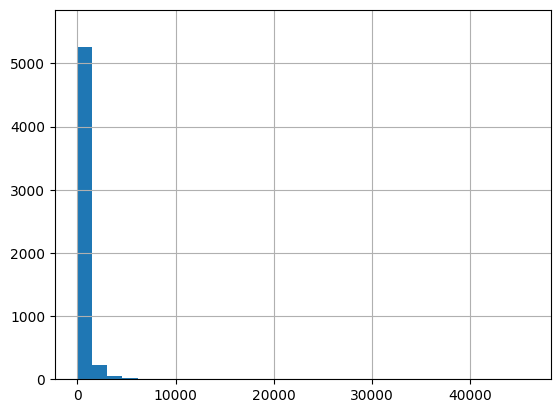

In [ ]:
labels_d1 = df_1copy.iloc[:, 0].values  # Extract the first column (labels)
texts_d1 = df_1copy.iloc[:, 3].values   # Extract the second column (text)
df_1_subject = df_1copy.iloc[:, 2].values

#Finding max length
max_length_d1 = find_max_squence_length(texts_d1)
print(f"max length of text: {max_length_d1}")
max_length_subjectline_d1 = find_max_squence_length(df_1_subject)
print(f"max length of subejct line{max_length_subjectline_d1}")

#getting embeddings
chunksize = 240
text_chunks_labels_d1, text_embeddings_d1, chunk_num_d1 = get_embeddings_labels(texts_d1, df_1_subject, labels_d1, chunksize)

#Splitting training and validation features/labels
training_embeddings_d1 = text_embeddings_d1[:3343]
validation_embeddings_d1 = text_embeddings_d1[3343:4457]
#Splitting labels
labels = [torch.tensor(item).unsqueeze(0) for item in text_chunks_labels_d1]
training_labels_d1 = labels[:3343]
validation_labels_d1 = labels[3343:4457]
#Splitting chunknums
chunknum = [torch.tensor(item) for item in chunk_num_d1]
training_chunknum_d1 = chunknum[:3343]
validation_chunknum_d1 = chunknum[3343:4457]

#Test data for data set 1
test_embeddings_d1 = text_embeddings_d1[4457:5572]
test_labels_d1 = labels[4457:5572]
test_chunknum_d1 = chunknum[4457:5572]

In [ ]:
print(len(text_embeddings_d1))

47457


In [ ]:
extralabels = np.array(training_labels_d1)  # Ensure it's a NumPy array
count_0 = np.sum(extralabels == 0)
count_1 = np.sum(extralabels == 1)
print(count_0,count_1)

2100 1243


In [ ]:
#Balancing training set
extra_embeddings, extra_chunknum, extra_labels = get_duplicate_spam_embeddings(training_embeddings_d1, training_labels_d1, training_chunknum_d1)
extra_embeddings_nonspam, extra_chunknum_nonspam, extra_labels_nonspam = get_duplicate_nonspam_embeddings(training_embeddings_d1, training_labels_d1, training_chunknum_d1)



In [ ]:
#Add embeddings, labels, and chunknums to original trainingset
training_embeddings_d1.extend(extra_embeddings[:857])
training_labels_d1.extend(extra_labels[:857])
training_chunknum_d1.extend(extra_chunknum[:857])

In [ ]:
print(training_chunknum_d1)
print(training_labels_d1)
print(len(training_chunknum_d1))
print(len(training_labels_d1))
print(len(training_embeddings_d1))


[tensor(0), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(2), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3)

In [ ]:
#Loading data using https://towardsdatascience.com/how-to-use-datasets-and-dataloader-in-pytorch-for-custom-text-data-270eed7f7c00/
class Newdataset(Dataset):
    def __init__(self, text_embeddings, labels, chunknum):
        """
        Args:
            data (list or torch.Tensor): List of input data or a PyTorch tensor.
            labels (list or torch.Tensor): List of labels or a PyTorch tensor.
        """
        self.text_embeddings = text_embeddings
        self.labels = labels
        self.chunknum = chunknum

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.text_embeddings)

    def __getitem__(self, idx):
        """Retrieves a sample from the dataset at the given index."""
        input_ids = self.text_embeddings[idx]["input_ids"]
        attention_mask = self.text_embeddings[idx]["attention_mask"]
        label = self.labels[idx]
        chunknum = self.chunknum[idx]

        return input_ids, attention_mask, label, chunknum

In [ ]:
train_set_d1 = Newdataset(training_embeddings_d1, training_labels_d1, training_chunknum_d1)
validation_set_d1 = Newdataset(validation_embeddings_d1, validation_labels_d1, validation_chunknum_d1)

#Getting embeddings, labels, and chunk index for Dataset 2

In [ ]:
df_2copy = df_2.copy()
df_2copy

,label,text,subject line,combined_text
0,0,[EMAILBODY] this is a follow up to the note i ...,[SUB] enron methanol ; meter # : 988291,[SUB] enron methanol ; meter # : 988291 [EMAI...
1,0,[EMAILBODY] ( see attached file : hplnol 09 . ...,"[SUB] hpl nom for january 9 , 2001","[SUB] hpl nom for january 9 , 2001 [EMAILBODY..."
2,0,"[EMAILBODY] ho ho ho , we ' re around to that ...",[SUB] neon retreat,"[SUB] neon retreat [EMAILBODY] ho ho ho , we ..."
3,1,[EMAILBODY] abasements darer prudently fortuit...,"[SUB] photoshop , windows , office . cheap . ...","[SUB] photoshop , windows , office . cheap . ..."
4,0,[EMAILBODY] this deal is to book the teco pvr ...,[SUB] re : indian springs,[SUB] re : indian springs [EMAILBODY] this de...
...,...,...,...,...
4988,0,[EMAILBODY] 9868 please note the following for...,"[SUB] fw : crosstex energy , driscoll ranch #...","[SUB] fw : crosstex energy , driscoll ranch #..."
4989,0,[EMAILBODY] the transport volumes decreased fr...,[SUB] put the 10 on the ft,[SUB] put the 10 on the ft [EMAILBODY] the tr...
4990,0,[EMAILBODY] hpl can ' t take the extra 15 mmcf...,[SUB] 3 / 4 / 2000 and following noms,[SUB] 3 / 4 / 2000 and following noms [EMAILB...
4991,0,[EMAILBODY] attached are the worksheets for au...,[SUB] industrial worksheets for august 2000 a...,[SUB] industrial worksheets for august 2000 a...


max length of text: 12764
max length of subejct line: 731


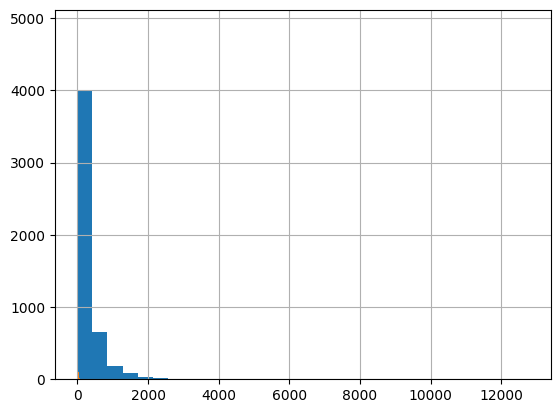

In [ ]:
labels_d2 = df_2copy.iloc[:, 0].values  # Extract the first column (labels)
texts_d2 = df_2copy.iloc[:, 3].values   # Extract the second column (text)
df_2_subject = df_2copy.iloc[:, 2].values

#Finding max length
#max_length_cd = find_max_squence_length(texts_cd)
max_length_d2 = find_max_squence_length(texts_d2)
print(f"max length of text: {max_length_d2}")
max_length_subjectline_d2 = find_max_squence_length(df_2_subject)
print(f"max length of subejct line: {max_length_subjectline_d2}")

#Find embeddings
chunksize = 240
text_chunks_labels_d2, text_embeddings_d2, chunk_num_d2 = get_embeddings_labels(texts_d2, df_2_subject ,labels_d2,chunksize)

#Splitting training and validation features/labels
training_embeddings_d2 = text_embeddings_d2[:2995]
validation_embeddings_d2 = text_embeddings_d2[2995:3994]
#Splitting labels
labelsd2 = [torch.tensor(item).unsqueeze(0) for item in text_chunks_labels_d2]
training_labels_d2 = labelsd2[:2995]
validation_labels_d2 = labelsd2[2995:3994]
#Splitting chunknums
chunknumd2 = [torch.tensor(item) for item in chunk_num_d2]
training_chunknum_d2 = chunknumd2[:2995]
validation_chunknum_d2 = chunknumd2[2995:3994]

#Test data for dataset 2
test_embeddings_d2 = text_embeddings_d2[3994:4993]
test_labels_d2 = labelsd2[3994:4993]
test_chunknum_d2 = chunknumd2[3994:4993]

In [ ]:
extralabels = np.array(training_labels_d2)  # Ensure it's a NumPy array
count_0 = np.sum(extralabels == 0)
count_1 = np.sum(extralabels == 1)
print(count_0,count_1)

1946 1049


In [ ]:
#Balancing training set
extra_embeddings_d2, extra_chunknum_d2, extra_labels_d2 = get_duplicate_spam_embeddings(training_embeddings_d2, training_labels_d2, training_chunknum_d2)
extra_embeddings_d2_nonspam, extra_chunknum_d2_nonspam, extra_labels_d2_nonspam = get_duplicate_nonspam_embeddings(training_embeddings_d2, training_labels_d2, training_chunknum_d2)

In [ ]:
#Add embeddings, labels, and chunknums to original trainingset
training_embeddings_d2.extend(extra_embeddings_d2)
training_labels_d2.extend(extra_labels_d2)
training_chunknum_d2.extend(extra_chunknum_d2)

In [ ]:
print(len(training_chunknum_d2))
print(len(training_labels_d2))
print(len(training_embeddings_d2))

4044
4044
4044


# Getting embeddings, labels, and chunk index for combined Dataset

In [ ]:
combined_dfcopy = combined_df.copy()
combined_dfcopy

,label,text,subject line,combined_text
0,0,[EMAILBODY] for rings escapenumber escapenumbe...,[NOSUB],[NOSUB] [EMAILBODY] for rings escapenumber esc...
1,1,[EMAILBODY] dear tracy it's the american airli...,[NOSUB],[NOSUB] [EMAILBODY] dear tracy it's the americ...
2,0,[EMAILBODY] at escapenumber escapenumber est i...,[NOSUB],[NOSUB] [EMAILBODY] at escapenumber escapenumb...
3,0,[EMAILBODY] isda press report december escapen...,[NOSUB],[NOSUB] [EMAILBODY] isda press report december...
4,0,[EMAILBODY] hello here's a copy of the blue mo...,[NOSUB],[NOSUB] [EMAILBODY] hello here's a copy of the...
...,...,...,...,...
10560,0,[EMAILBODY] 9868 please note the following for...,"[SUB] fw : crosstex energy , driscoll ranch #...","[SUB] fw : crosstex energy , driscoll ranch #..."
10561,0,[EMAILBODY] the transport volumes decreased fr...,[SUB] put the 10 on the ft,[SUB] put the 10 on the ft [EMAILBODY] the tr...
10562,0,[EMAILBODY] hpl can ' t take the extra 15 mmcf...,[SUB] 3 / 4 / 2000 and following noms,[SUB] 3 / 4 / 2000 and following noms [EMAILB...
10563,0,[EMAILBODY] attached are the worksheets for au...,[SUB] industrial worksheets for august 2000 a...,[SUB] industrial worksheets for august 2000 a...


max length of text: 45932
max length of subejct line: 731


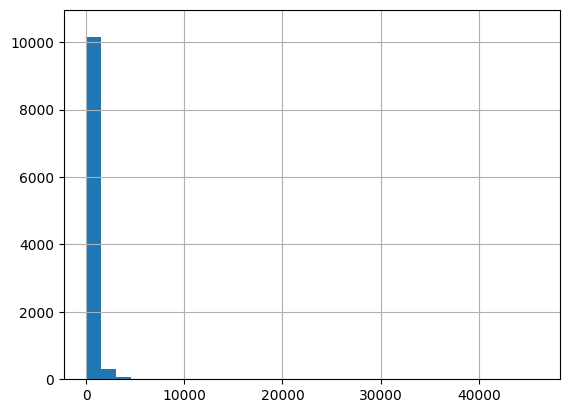

In [ ]:
labels_cd = combined_dfcopy.iloc[:, 0].values  # Extract the first column (labels)
texts_cd = combined_dfcopy.iloc[:, 3].values   # Extract the second column (text)
df_cd_subject = combined_dfcopy.iloc[:, 2].values

#Finding max length
#max_length_cd = find_max_squence_length(texts_cd)
max_length_cd = find_max_squence_length(texts_cd)
print(f"max length of text: {max_length_cd}")
max_length_subjectline_cd = find_max_squence_length(df_cd_subject)
print(f"max length of subejct line: {max_length_subjectline_cd}")


#Find embeddings
chunksize = 240
text_chunks_labels_cd, text_embeddings_cd, chunk_num_cd = get_embeddings_labels(texts_cd, df_cd_subject, labels_cd,chunksize)

#Splitting training and validation features/labels
training_embeddings_cd = text_embeddings_cd[:6339]
validation_embeddings_cd = text_embeddings_cd[6339:8452]
#Splitting labels
labelscd = [torch.tensor(item).unsqueeze(0) for item in text_chunks_labels_cd]
training_labels_cd = labelscd[:6339]
validation_labels_cd = labelscd[6339:8452]
#Splitting chunknums
chunknumcd = [torch.tensor(item) for item in chunk_num_cd]
training_chunknum_cd = chunknumcd[:6339]
validation_chunknum_cd = chunknumcd[6339:8452]

#Test data
test_embeddings_cd = text_embeddings_cd[8452:10565]
test_labels_cd = labelscd[8452:10565]
test_chunknum_cd = chunknumcd[8452:10565]

10508


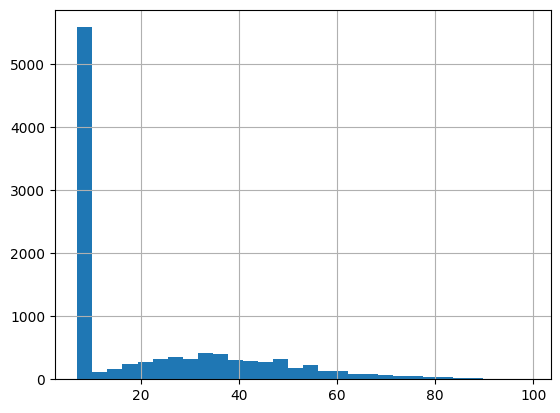

In [ ]:
print(find_max_squence(df_cd_subject, 100))

In [ ]:
print(len(text_embeddings_cd))

72004


In [ ]:
extralabels = np.array(training_labels_cd)  # Ensure it's a NumPy array
count_0 = np.sum(extralabels == 0)
count_1 = np.sum(extralabels == 1)
print(count_0,count_1)

4163 2176


In [ ]:
#Balancing training set
extra_embeddings_cd_spam, extra_chunknum_cd_spam, extra_labels_cd_spam = get_duplicate_spam_embeddings(training_embeddings_cd, training_labels_cd, training_chunknum_cd)

In [ ]:
#Add embeddings, labels, and chunknums to original trainingset
training_embeddings_cd.extend(extra_embeddings_cd_spam)
training_labels_cd.extend(extra_labels_cd_spam)
training_chunknum_cd.extend(extra_chunknum_cd_spam)

In [ ]:
print(training_chunknum_cd)
print(training_labels_cd)
print(len(training_chunknum_cd))
print(len(training_labels_cd))
print(len(training_embeddings_cd))

[tensor(0), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(2), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3)

In [ ]:
train_set_cd = Newdataset(training_embeddings_cd, training_labels_cd, training_chunknum_cd)
validation_set_cd = Newdataset(validation_embeddings_cd, validation_labels_cd, validation_chunknum_cd)

#Training Functions


In [ ]:
#Resources Used: Lab 2

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch, num):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}_{4}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch, num)
    return path


def evaluate(net, loader, criterion, new = True):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set

     """
    net.cuda()
    net.eval()

    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        print(f"iter in eval{i}")
        input_ids, attention_mask, labels, _ = data
        if torch.cuda.is_available():
          input_ids = input_ids.cuda()
          labels = labels.cuda()
          attention_mask = attention_mask.cuda()
        outputs = net(input_ids = input_ids.squeeze(1), attention_mask = attention_mask.squeeze(1))

        if i == 33: # Check if it's the last iteration
            print("--- LAST ITERATION DEBUG INFO ---")
            print("Raw Outputs:", outputs)
            print("Sigmoid Outputs:", torch.sigmoid(outputs))
            print("Normalized Labels:", labels)

        loss = criterion(outputs, labels.float())
        print(loss.item())
        predictions = (torch.sigmoid(outputs) > 0.5).long()
        mismatches = (predictions!= labels)
        total_err += int(mismatches.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

def evaluate_test(net, loader, criterion, new = True):


    predictions_list = []
    true_labels_list = []
    chunk_num_list = []
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        print(f"iter{i}")
        if new:
          input_ids, attention_mask, labels, chunknum = data
          if torch.cuda.is_available():
            input_ids = input_ids.cuda()
            labels = labels.cuda()
            attention_mask = attention_mask.cuda()
        else:
          input, labels, _ = data
          if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()
        if new:
          outputs = net(input_ids = input_ids.squeeze(1), attention_mask = attention_mask.squeeze(1))
        else:
          outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        predictions = (torch.sigmoid(outputs) > 0.5).long()
        predictions_list.extend([x[0] for x in predictions.tolist()])
        true_labels_list.extend([x[0] for x in labels.tolist()])
        chunk_num_list.extend([tensor.item() for tensor in chunknum])
        # Calculate TP, TN, FP, FN
        mismatches = (predictions!= labels)
        total_err += int(mismatches.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    print(f"length of predictions list: {len(predictions_list)}")
    print(f"length of predictions list: {len(true_labels_list)}")
    print(f"length of predictions list: {len(chunk_num_list)}")
    if not (len(predictions_list) == len(true_labels_list) == len(chunk_num_list)):
      raise ValueError("All input lists must have the same length")

    # Get unique chunk numbers
    unique_chunks = sorted(set(chunk_num_list))

    # Initialize results dictionary and lists
    #results = {}
    chunk_majority_predictions = []
    chunk_true_labels = []

    # Process each chunk
    for chunk in unique_chunks:
        # Get indices for the current chunk
        indices = [i for i, num in enumerate(chunk_num_list) if num == chunk]

        # Get the true label for this chunk (should be the same for all indices in the chunk)
        chunk_true_label = true_labels_list[indices[0]]

        # Verify that all true labels in this chunk are the same
        if not all(true_labels_list[i] == chunk_true_label for i in indices):
            raise ValueError(f"True labels are not consistent within chunk {chunk}")

        # Get predictions for this chunk
        chunk_pred_labels = [predictions_list[i] for i in indices]

        # Determine majority prediction (1 if more 1s than 0s, otherwise 0)
        ones_count = sum(1 for pred in chunk_pred_labels if pred == 1)
        majority_prediction = 1 if ones_count > len(chunk_pred_labels)/2 else 0

        # Count how many predictions match the true label for this chunk
        matches = sum(1 for pred in chunk_pred_labels if pred == chunk_true_label)

        # Total items in this chunk
        total = len(indices)

        # Check if matches exceed half of the total
        #results[chunk] = 1 if matches > total / 2 else 0

        # Add to our result lists
        chunk_majority_predictions.append(majority_prediction)
        chunk_true_labels.append(chunk_true_label)





    return err, loss, chunk_majority_predictions, chunk_true_labels

###############################################################################
# Training Curve
def plot_training_curve(path, num):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title(f"Train vs Validation Error For Dataset {num}")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.savefig('{}_error.png'.format(path))
    plt.show()
    plt.title(f"Train vs Validation Loss For Dataset{num}")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.savefig('{}_loss.png'.format(path))
    plt.show()


def find_val(path):
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    mean_val_err = val_err[-1]
    mean_val_loss = val_loss[-1]
    print(f"The final validation error and loss for {path} is {mean_val_err} and {mean_val_loss} respectively")

def find_min_epoch(path):
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    min_val_err = val_err.min()
    min_epoch = np.argmin(val_err)
    print(f"The minimum validation error for {path} is {min_val_err} at epoch {min_epoch+1}")
    return min_epoch

# Train Function

In [ ]:
def train(net, train_set, validation_set, data_setnum, batch_size=64, learning_rate=0.01, num_epochs=100, new = True):
    # Load data
    validation_loader = DataLoader(validation_set, batch_size= batch_size)
    train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Define the Loss function and optimizer
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(net.parameters(), lr=learning_rate, weight_decay = 0.015)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        start_time2 = time.time()
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            print(f"iter{i}")
            # Get the inputs
            input_ids, attention_mask, labels, _ = data
            if torch.cuda.is_available():
              input_ids = input_ids.cuda()
              labels = labels.cuda()
              attention_mask = attention_mask.cuda()
            #To Enable GPU Usage
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(input_ids = input_ids.squeeze(1), attention_mask = attention_mask.squeeze(1))
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            predictions = ((outputs) > 0.0).long()
            mismatches = (predictions!= labels)
            #print(f"labels:{labels}")
            #print(f"predictions: {predictions}")
            #break
            total_train_err += int(mismatches.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, validation_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch, data_setnum)
        torch.save(net.state_dict(), model_path)
        end_time2 = time.time()
        elapsed_time2 = end_time2 - start_time2
        print("Total time elapsed: {:.2f} seconds per epoch".format(elapsed_time2))
    print(model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

# Defining the Model


In [ ]:
#Code adapted from inspired by:
#https://medium.com/@heyamit10/fine-tuning-bert-for-classification-a-practical-guide-b8c1c56f252c
#https://discuss.huggingface.co/t/freeze-lower-layers-with-auto-classification-model/11386

'''
for name, param in model.named_parameters():
     if name.startswith("..."): # choose whatever you like here
        param.requires_grad = False
'''

# Initialize the model with the modified config
bert = DistilBertModel.from_pretrained("distilbert-base-cased")
bert.resize_token_embeddings(len(tokenizer))

#Defining the model and methods
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.name = "SpamClassifierV2"
        self.bert = bert
        self.fc1 = nn.Linear(768, 1)
        self.dropout = nn.Dropout(0.7)


        self.fc1.reset_parameters()
        print("Weights of fc2 and fc3 have been reset upon instantiation.")

    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids = input_ids, attention_mask = attention_mask)
        x = x.last_hidden_state[:,0,:] #Get [CLS] token representation from the last hidden state
        x = self.dropout(x)
        x = self.fc1(x)

        return x

In [ ]:

finetuned_model = Model()
if torch.cuda.is_available():
  finetuned_model = finetuned_model.cuda()
# Resize the model's embedding layer to match the new vocabulary size

for name,param in finetuned_model.named_parameters():
  param.requires_grad = True


count = 0
for name,param in finetuned_model.named_parameters():
  count += 1
  if count <= 84:
    param.requires_grad = False
  else:
    break

count = 0

for name,param in finetuned_model.named_parameters():
  count += 1
  if count <= 100:
    print(param.requires_grad, name)
  else:
    break


Weights of fc2 and fc3 have been reset upon instantiation.
False bert.embeddings.word_embeddings.weight
False bert.embeddings.position_embeddings.weight
False bert.embeddings.LayerNorm.weight
False bert.embeddings.LayerNorm.bias
False bert.transformer.layer.0.attention.q_lin.weight
False bert.transformer.layer.0.attention.q_lin.bias
False bert.transformer.layer.0.attention.k_lin.weight
False bert.transformer.layer.0.attention.k_lin.bias
False bert.transformer.layer.0.attention.v_lin.weight
False bert.transformer.layer.0.attention.v_lin.bias
False bert.transformer.layer.0.attention.out_lin.weight
False bert.transformer.layer.0.attention.out_lin.bias
False bert.transformer.layer.0.sa_layer_norm.weight
False bert.transformer.layer.0.sa_layer_norm.bias
False bert.transformer.layer.0.ffn.lin1.weight
False bert.transformer.layer.0.ffn.lin1.bias
False bert.transformer.layer.0.ffn.lin2.weight
False bert.transformer.layer.0.ffn.lin2.bias
False bert.transformer.layer.0.output_layer_norm.weight
F

# Training

In [ ]:
#Training for combined dataset:
train(finetuned_model, train_set_cd, validation_set_cd, 5, batch_size=64, learning_rate=0.0001, num_epochs=10, new = True)

iter0
iter1
iter2
iter3
iter4
iter5
iter6
iter7
iter8
iter9
iter10
iter11
iter12
iter13
iter14
iter15
iter16
iter17
iter18
iter19
iter20
iter21
iter22
iter23
iter24
iter25
iter26
iter27
iter28
iter29
iter30
iter31
iter32
iter33
iter34
iter35
iter36
iter37
iter38
iter39
iter40
iter41
iter42
iter43
iter44
iter45
iter46
iter47
iter48
iter49
iter50
iter51
iter52
iter53
iter54
iter55
iter56
iter57
iter58
iter59
iter60
iter61
iter62
iter63
iter64
iter65
iter66
iter67
iter68
iter69
iter70
iter71
iter72
iter73
iter74
iter75
iter76
iter77
iter78
iter79
iter80
iter81
iter82
iter83
iter84
iter85
iter86
iter87
iter88
iter89
iter90
iter91
iter92
iter93
iter94
iter95
iter96
iter97
iter98
iter99
iter100
iter101
iter102
iter103
iter104
iter105
iter106
iter107
iter108
iter109
iter110
iter111
iter112
iter113
iter114
iter115
iter116
iter117
iter118
iter119
iter120
iter121
iter122
iter123
iter124
iter125
iter126
iter127
iter128
iter129
iter130
iter131
iter132
iter133
iter in eval0
0.6145397424697876
iter 

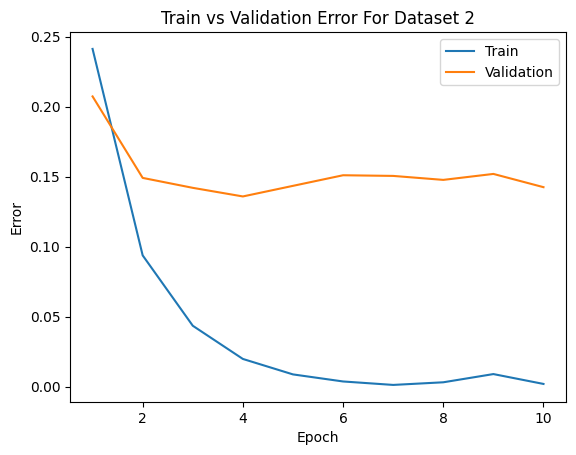

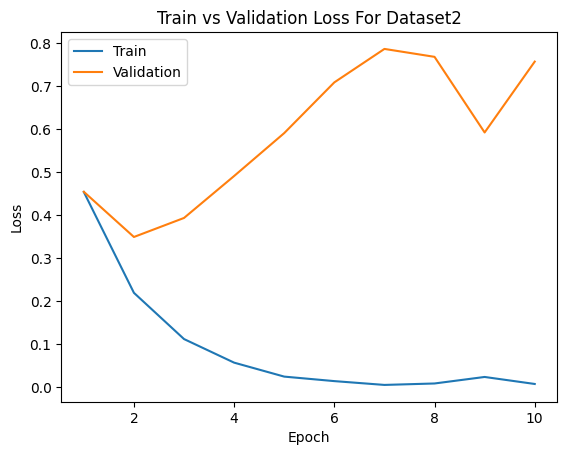

In [ ]:
plot_training_curve(get_model_name("SpamClassifierV2", 64, 0.0001, 9,5), 2)

In [ ]:
#Testing on combined:
spam_classifier = Model()
if torch.cuda.is_available():
  spam_classifier = spam_classifier.cuda()
model_path_2 = get_model_name("SpamClassifierV2", 64, 0.0001, 1,5)
modelstate = torch.load(model_path_2)
spam_classifier.load_state_dict(modelstate)
criterion = nn.BCEWithLogitsLoss()
#test_features = features
#test_labels = [torch.tensor(item).unsqueeze(0) for item in test_chunks_labels]
test_set = Newdataset(test_embeddings_cd, test_labels_cd, test_chunknum_cd)
test_loader = DataLoader(test_set, batch_size= 64, shuffle = True)
test_err, test_loss, predictions_list_cd, true_labels_list_cd = evaluate_test(spam_classifier, test_loader, criterion)
print((f"test error: {test_err}"))
print((f"test accruacy: {1-test_err}"))

Weights of fc2 and fc3 have been reset upon instantiation.
iter0
iter1
iter2
iter3
iter4
iter5
iter6
iter7
iter8
iter9
iter10
iter11
iter12
iter13
iter14
iter15
iter16
iter17
iter18
iter19
iter20
iter21
iter22
iter23
iter24
iter25
iter26
iter27
iter28
iter29
iter30
iter31
iter32
iter33
length of predictions list: 2113
length of predictions list: 2113
length of predictions list: 2113
test error: 0.150970184571699
test accruacy: 0.849029815428301


In [ ]:
#Testing on d1:
spam_classifier = Model()
if torch.cuda.is_available():
  spam_classifier = spam_classifier.cuda()
model_path_2 = get_model_name("SpamClassifierV2", 64, 0.0001, 1,5)
modelstate = torch.load(model_path_2)
spam_classifier.load_state_dict(modelstate)
criterion = nn.BCEWithLogitsLoss()
#test_features = features
#test_labels = [torch.tensor(item).unsqueeze(0) for item in test_chunks_labels]
test_set = Newdataset(test_embeddings_d1, test_labels_d1, test_chunknum_d1)
test_loader = DataLoader(test_set, batch_size= 64, shuffle = True)
test_err, test_loss, predictions_list_d1, true_labels_list_d1 = evaluate_test(spam_classifier, test_loader, criterion)
print((f"test error: {test_err}"))
print((f"test accruacy: {1-test_err}"))

Weights of fc2 and fc3 have been reset upon instantiation.
iter0
iter1
iter2
iter3
iter4
iter5
iter6
iter7
iter8
iter9
iter10
iter11
iter12
iter13
iter14
iter15
iter16
iter17
length of predictions list: 1115
length of predictions list: 1115
length of predictions list: 1115
test error: 0.030493273542600896
test accruacy: 0.9695067264573991


In [ ]:
#Testing on d2:
spam_classifier = Model()
if torch.cuda.is_available():
  spam_classifier = spam_classifier.cuda()
model_path_2 = get_model_name("SpamClassifierV2", 64, 0.0001, 1,5)
modelstate = torch.load(model_path_2)
spam_classifier.load_state_dict(modelstate)
criterion = nn.BCEWithLogitsLoss()
#test_features = features
#test_labels = [torch.tensor(item).unsqueeze(0) for item in test_chunks_labels]
test_set = Newdataset(test_embeddings_d2, test_labels_d2, test_chunknum_d2)
test_loader = DataLoader(test_set, batch_size= 64, shuffle = True)
test_err, test_loss, predictions_list_d2, true_labels_list_d2 = evaluate_test(spam_classifier, test_loader, criterion)
print((f"test error: {test_err}"))
print((f"test accruacy: {1-test_err}"))

Weights of fc2 and fc3 have been reset upon instantiation.
iter0
iter1
iter2
iter3
iter4
iter5
iter6
iter7
iter8
iter9
iter10
iter11
iter12
iter13
iter14
iter15
length of predictions list: 999
length of predictions list: 999
length of predictions list: 999
test error: 0.10710710710710711
test accruacy: 0.8928928928928929


# Confusion Matrices

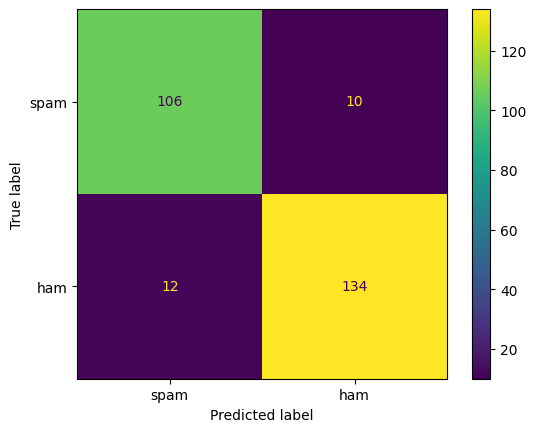

In [ ]:
#Confusion matrix for combined dataset
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels_list_cd, predictions_list_cd, labels = [1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["spam", "ham"])
disp.plot()
plt.savefig('confusionmatrix_for_dataset1.png')
plt.show()

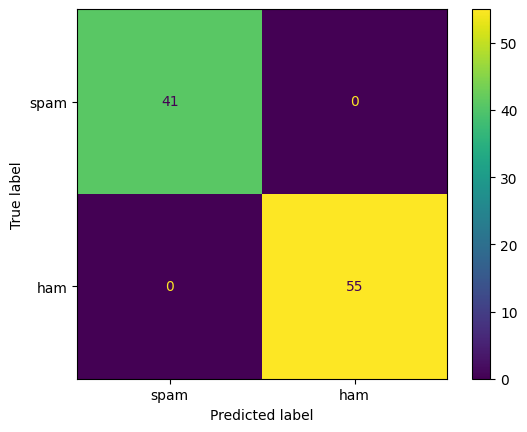

In [ ]:
#Confusion matrix for dataset 1
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels_list_d1, predictions_list_d1, labels = [1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["spam", "ham"])
disp.plot()
plt.savefig('confusionmatrix_for_dataset2.png')
plt.show()

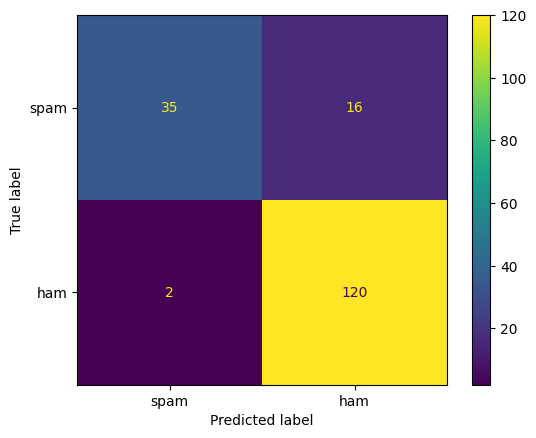

In [ ]:
#Confusion matrix for dataset 2
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels_list_d2, predictions_list_d2, labels = [1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["spam", "ham"])
disp.plot()
plt.savefig('confusionmatrix_for_datasetcombined.png')
plt.show()

# Testing Data

In [ ]:
import kagglehub
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("mandygu/lingspam-dataset")

print("Path to dataset files:", path)


# Define dataset path
dataset_folder = path  # This is the downloaded dataset folder

# List files in the dataset folder
files = os.listdir(dataset_folder)
print("Dataset files:", files)

# Load a CSV file into pandas
csv_file = os.path.join(dataset_folder, files[0]) # Replace with actual file name
df = pd.read_csv(csv_file, encoding='ISO-8859-1')


# utilizing 2 differnet datasets
df_test = df.copy()
# cleaning df_1
# Rename relevant columns

df_test = df_test[['label', 'message', 'subject']]
df_test.columns = ['label', 'text', 'subject']


# Display first few rows
df_test

for i in ['text', 'subject']:
    # Remove multiple spaces
    df_test[i] = df_test[i].str.strip()
    df_test[i] = df_test[i].str.replace(r'\s+', ' ', regex=True)

    # Fix encoding issues since there are random symbols such as: â, Âº, etc.
    df_test[i] = df_test[i].str.encode('ascii', 'ignore').str.decode('utf-8')

    # Removing number placeholders (&lt;#&gt)
    df_test[i] = df_test[i].str.replace(r'&lt;#&gt;', '[NUMBER]', regex=True)

    # Removing URL placeholders (&lt;URL&gt;)
    df_test[i] = df_test[i].str.replace(r'&lt;URL&gt;', '[URL]', regex=True)

    # Removing decimal placeholders (&lt;DECIMAL&gt;)
    df_test[i] = df_test[i].str.replace(r'&lt;DECIMAL&gt;', '[DECIMAL]', regex=True)

    # Removing time placeholders (&lt;TIME&gt;)
    df_test[i] = df_test[i].str.replace(r'&lt;TIME&gt;', '[TIME]', regex=True)

    # Removing email placeholders (&lt;EMAIL&gt;)
    df_test[i] = df_test[i].str.replace(r'&lt;EMAIL&gt;', '[EMAIL]', regex=True)

    # Remove all occurrences of '&gt;' (greater-than sign encoding)
    df_test[i] = df_test[i].str.replace(r'&gt;', '', regex=True)

df_test

Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\mandygu\lingspam-dataset\versions\1
Dataset files: ['messages.csv']


,label,text,subject
0,0,content - length : 3386 apple-iss research cen...,job posting - apple-iss research center
1,0,"lang classification grimes , joseph e . and ba...",NaN
2,0,i am posting this inquiry for sergei atamas ( ...,query : letter frequencies for text identifica...
3,0,a colleague and i are researching the differin...,risk
4,0,earlier this morning i was on the phone with a...,request book information
...,...,...,...
2888,1,hello thanks for stopping by ! ! we have taken...,love your profile - ysuolvpv
2889,1,"the list owner of : "" kiddin "" has invited you...",you have been asked to join kiddin
2890,0,"judging from the return post , i must have sou...",anglicization of composers ' names
2891,0,gotcha ! there are two separate fallacies in t...,"re : 6 . 797 , comparative method : n - ary co..."


# Demo


In [ ]:
df_test_copy = df_test.copy()
df_test_copy_subset = df_test_copy.sample(n=500, random_state=42)  # Set random_state for reproducibility
df_test_copy_subset.loc[df_test_copy_subset.index[:250], "subject"] = "NaN"
df_test_copy_subset

,label,text,subject
1905,0,the university of edinburgh institute for appl...,NaN
1055,0,"2 years ago , my wife and i adopted two kids f...",NaN
2471,1,* * * * * * * * * * * * * * * * attention vide...,NaN
1133,0,am sprachwissenschaftlichen institut der unive...,NaN
1200,0,mind iii : annual conference of the cognitive ...,NaN
...,...,...,...
1763,0,i was curious if anyone was actually intereste...,dick armey 's slip and correction
677,1,subliminally entice any woman to be yours ! gu...,fast delivery
565,0,"on february 27 , i posted a querry on expletiv...",summary : expletive negation in modern hebrew
1260,0,syntax & morphology spontaneous spoken languag...,new books in syntax & morphology


In [ ]:
df_test_copy = df_test.copy()
df_test_copy_subset = df_test_copy.sample(n=500, random_state=42)  # Set random_state for reproducibility
df_test_copy_subset.loc[df_test_copy_subset.index[:250], "subject"] = "NaN"
df_test_copy_subset["subject"] = df_test_copy_subset["subject"].fillna("NaN")
df_test_copy_subset["subject"] = np.where(
    df_test_copy_subset["subject"] != "NaN",  # Check if "subject" is NOT the string "NaN"
    "[SUB] " + df_test_copy_subset["subject"],   # If condition is True, use this
    "[NOSUB]"                           # Else, use "[NOSUB]"
)
df_test_copy_subset['text'] = '[EMAILBODY]'+ " " + df_test_copy_subset['text']
df_test_copy_subset['combined_text'] = df_test_copy_subset['subject'] + " " + df_test_copy_subset['text']
df_test_copy_subset

,label,text,subject,combined_text
1905,0,[EMAILBODY] the university of edinburgh instit...,[NOSUB],[NOSUB] [EMAILBODY] the university of edinburg...
1055,0,"[EMAILBODY] 2 years ago , my wife and i adopte...",[NOSUB],"[NOSUB] [EMAILBODY] 2 years ago , my wife and ..."
2471,1,[EMAILBODY] * * * * * * * * * * * * * * * * at...,[NOSUB],[NOSUB] [EMAILBODY] * * * * * * * * * * * * * ...
1133,0,[EMAILBODY] am sprachwissenschaftlichen instit...,[NOSUB],[NOSUB] [EMAILBODY] am sprachwissenschaftliche...
1200,0,[EMAILBODY] mind iii : annual conference of th...,[NOSUB],[NOSUB] [EMAILBODY] mind iii : annual conferen...
...,...,...,...,...
1763,0,[EMAILBODY] i was curious if anyone was actual...,[SUB] dick armey 's slip and correction,[SUB] dick armey 's slip and correction [EMAIL...
677,1,[EMAILBODY] subliminally entice any woman to b...,[SUB] fast delivery,[SUB] fast delivery [EMAILBODY] subliminally e...
565,0,"[EMAILBODY] on february 27 , i posted a querry...",[SUB] summary : expletive negation in modern h...,[SUB] summary : expletive negation in modern h...
1260,0,[EMAILBODY] syntax & morphology spontaneous sp...,[SUB] new books in syntax & morphology,[SUB] new books in syntax & morphology [EMAILB...


max length of text: 7019
max length of subejct line47


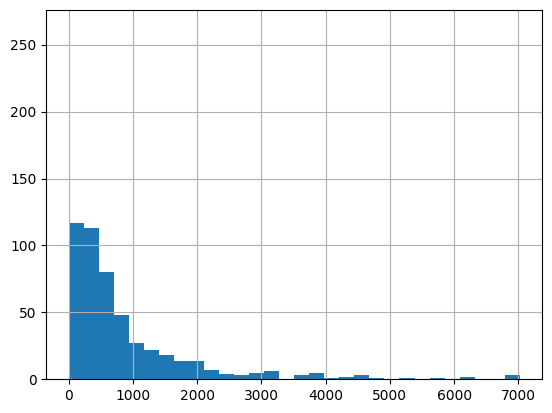

In [ ]:
#Get embedding and labels for testset:
labels_test = df_test_copy_subset.iloc[:, 0].values  # Extract the first column (labels)
texts_test = df_test_copy_subset.iloc[:, 3].values   # Extract the second column (text)
test_subject = df_test_copy_subset.iloc[:, 2].values

#Finding max length
max_length_test = find_max_squence_length(texts_test)
print(f"max length of text: {max_length_test}")
max_length_subjectline_test = find_max_squence_length(test_subject)
print(f"max length of subejct line{max_length_subjectline_test}")

#getting embeddings
chunksize = 240
text_chunks_labels_test, text_embeddings_test, chunk_num_test = get_embeddings_labels(texts_test, test_subject, labels_test, chunksize)

#Converting to tensors
#Splitting labels
labels_test = [torch.tensor(item).unsqueeze(0) for item in text_chunks_labels_test]

#Splitting chunknums
chunknum_test = [torch.tensor(item) for item in chunk_num_test]

In [ ]:
#Testing on testset:
spam_classifier = Model()
if torch.cuda.is_available():
  spam_classifier = spam_classifier.cuda()
model_path_2 = get_model_name("SpamClassifierV2", 64, 0.0001, 1,5)
modelstate = torch.load(model_path_2)
spam_classifier.load_state_dict(modelstate)
criterion = nn.BCEWithLogitsLoss()
#test_features = features
#test_labels = [torch.tensor(item).unsqueeze(0) for item in test_chunks_labels]
test_set = Newdataset(text_embeddings_test, labels_test, chunknum_test)
test_loader = DataLoader(test_set, batch_size= 64, shuffle = True)
test_err, test_loss, predictions_list_test, true_labels_list_test = evaluate_test(spam_classifier, test_loader, criterion)
print((f"test error: {test_err}"))
print((f"test accruacy: {1-test_err}"))

Weights of fc2 and fc3 have been reset upon instantiation.
iter0
iter1
iter2
iter3
iter4
iter5
iter6
iter7
iter8
iter9
iter10
iter11
iter12
iter13
iter14
iter15
iter16
iter17
iter18
iter19
iter20
iter21
iter22
iter23
iter24
iter25
iter26
iter27
iter28
iter29
iter30
iter31
iter32
iter33
iter34
iter35
iter36
iter37
iter38
iter39
iter40
iter41
iter42
iter43
iter44
iter45
iter46
iter47
iter48
iter49
iter50
iter51
iter52
iter53
iter54
iter55
iter56
iter57
iter58
iter59
iter60
iter61
iter62
iter63
iter64
iter65
iter66
iter67
iter68
iter69
iter70
iter71
iter72
iter73
iter74
iter75
iter76
iter77
iter78
iter79
iter80
iter81
iter82
iter83
iter84
iter85
iter86
iter87
iter88
iter89
iter90
iter91
iter92
iter93
iter94
iter95
iter96
iter97
iter98
iter99
iter100
iter101
iter102
iter103
iter104
iter105
iter106
iter107
iter108
iter109
iter110
iter111
iter112
iter113
iter114
iter115
iter116
iter117
length of predictions list: 7494
length of predictions list: 7494
length of predictions list: 7494
test err

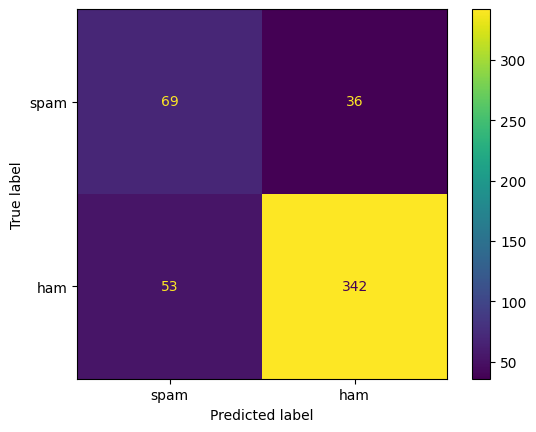

In [ ]:
#Confusion matrix for the test dataset
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels_list_test, predictions_list_test, labels = [1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["spam", "ham"])
disp.plot()
plt.savefig('confusionmatrix_for_dataset_test_demo.png')
plt.show()

# Full Test

In [ ]:
df_test_copy = df_test.copy()
df_test_copy.loc[:1445, "subject"] = "NaN"  # Use loc to directly modify the DataFrame
df_test_copy

,label,text,subject
0,0,content - length : 3386 apple-iss research cen...,NaN
1,0,"lang classification grimes , joseph e . and ba...",NaN
2,0,i am posting this inquiry for sergei atamas ( ...,NaN
3,0,a colleague and i are researching the differin...,NaN
4,0,earlier this morning i was on the phone with a...,NaN
...,...,...,...
2888,1,hello thanks for stopping by ! ! we have taken...,love your profile - ysuolvpv
2889,1,"the list owner of : "" kiddin "" has invited you...",you have been asked to join kiddin
2890,0,"judging from the return post , i must have sou...",anglicization of composers ' names
2891,0,gotcha ! there are two separate fallacies in t...,"re : 6 . 797 , comparative method : n - ary co..."


In [ ]:
print(df_test_copy["subject"].isna().sum())

12


In [ ]:
df_test_copy = df_test.copy()
df_test_copy.loc[:1445, "subject"] = "NaN"  # Use loc to directly modify the DataFrame
df_test_copy["subject"] = df_test_copy["subject"].fillna("NaN")
df_test_copy["subject"] = np.where(
    df_test_copy["subject"] != "NaN",  # Check if "subject" is NOT the string "NaN"
    "[SUB] " + df_test_copy["subject"],   # If condition is True, use this
    "[NOSUB]"                           # Else, use "[NOSUB]"
)
df_test_copy['text'] = '[EMAILBODY]'+ " " + df_test_copy['text']
df_test_copy['combined_text'] = df_test_copy['subject'] + " " + df_test_copy['text']
df_test_copy

,label,text,subject,combined_text
0,0,[EMAILBODY] content - length : 3386 apple-iss ...,[NOSUB],[NOSUB] [EMAILBODY] content - length : 3386 ap...
1,0,"[EMAILBODY] lang classification grimes , josep...",[NOSUB],[NOSUB] [EMAILBODY] lang classification grimes...
2,0,[EMAILBODY] i am posting this inquiry for serg...,[NOSUB],[NOSUB] [EMAILBODY] i am posting this inquiry ...
3,0,[EMAILBODY] a colleague and i are researching ...,[NOSUB],[NOSUB] [EMAILBODY] a colleague and i are rese...
4,0,[EMAILBODY] earlier this morning i was on the ...,[NOSUB],[NOSUB] [EMAILBODY] earlier this morning i was...
...,...,...,...,...
2888,1,[EMAILBODY] hello thanks for stopping by ! ! w...,[SUB] love your profile - ysuolvpv,[SUB] love your profile - ysuolvpv [EMAILBODY]...
2889,1,"[EMAILBODY] the list owner of : "" kiddin "" has...",[SUB] you have been asked to join kiddin,[SUB] you have been asked to join kiddin [EMAI...
2890,0,"[EMAILBODY] judging from the return post , i m...",[SUB] anglicization of composers ' names,[SUB] anglicization of composers ' names [EMAI...
2891,0,[EMAILBODY] gotcha ! there are two separate fa...,"[SUB] re : 6 . 797 , comparative method : n - ...","[SUB] re : 6 . 797 , comparative method : n - ..."


max length of text: 7775
max length of subejct line47


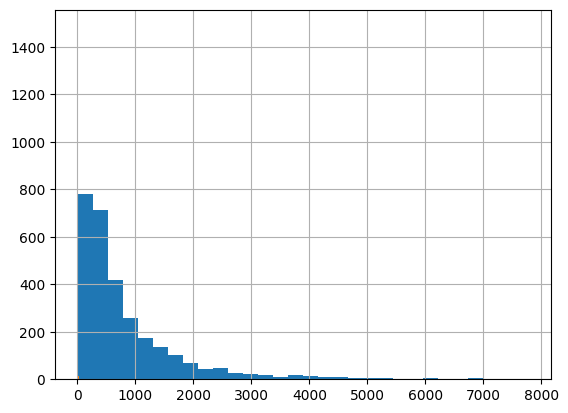

In [ ]:
#Get embedding and labels for testset:
labels_test = df_test_copy.iloc[:, 0].values  # Extract the first column (labels)
texts_test = df_test_copy.iloc[:, 3].values   # Extract the second column (text)
test_subject = df_test_copy.iloc[:, 2].values

#Finding max length
max_length_test = find_max_squence_length(texts_test)
print(f"max length of text: {max_length_test}")
max_length_subjectline_test = find_max_squence_length(test_subject)
print(f"max length of subejct line{max_length_subjectline_test}")

#getting embeddings
chunksize = 240
text_chunks_labels_test, text_embeddings_test, chunk_num_test = get_embeddings_labels(texts_test, test_subject, labels_test, chunksize)

#Converting to tensors
#Splitting labels
labels_test = [torch.tensor(item).unsqueeze(0) for item in text_chunks_labels_test]

#Splitting chunknums
chunknum_test = [torch.tensor(item) for item in chunk_num_test]



In [ ]:
#Testing on testset:
spam_classifier = Model()
if torch.cuda.is_available():
  spam_classifier = spam_classifier.cuda()
model_path_2 = get_model_name("SpamClassifierV2", 64, 0.0001, 1,5)
modelstate = torch.load(model_path_2)
spam_classifier.load_state_dict(modelstate)
criterion = nn.BCEWithLogitsLoss()
#test_features = features
#test_labels = [torch.tensor(item).unsqueeze(0) for item in test_chunks_labels]
test_set = Newdataset(text_embeddings_test, labels_test, chunknum_test)
test_loader = DataLoader(test_set, batch_size= 64, shuffle = True)
test_err, test_loss, predictions_list_test, true_labels_list_test = evaluate_test(spam_classifier, test_loader, criterion)
print((f"test error: {test_err}"))
print((f"test accruacy: {1-test_err}"))

Weights of fc2 and fc3 have been reset upon instantiation.
iter0
iter1
iter2
iter3
iter4
iter5
iter6
iter7
iter8
iter9
iter10
iter11
iter12
iter13
iter14
iter15
iter16
iter17
iter18
iter19
iter20
iter21
iter22
iter23
iter24
iter25
iter26
iter27
iter28
iter29
iter30
iter31
iter32
iter33
iter34
iter35
iter36
iter37
iter38
iter39
iter40
iter41
iter42
iter43
iter44
iter45
iter46
iter47
iter48
iter49
iter50
iter51
iter52
iter53
iter54
iter55
iter56
iter57
iter58
iter59
iter60
iter61
iter62
iter63
iter64
iter65
iter66
iter67
iter68
iter69
iter70
iter71
iter72
iter73
iter74
iter75
iter76
iter77
iter78
iter79
iter80
iter81
iter82
iter83
iter84
iter85
iter86
iter87
iter88
iter89
iter90
iter91
iter92
iter93
iter94
iter95
iter96
iter97
iter98
iter99
iter100
iter101
iter102
iter103
iter104
iter105
iter106
iter107
iter108
iter109
iter110
iter111
iter112
iter113
iter114
iter115
iter116
iter117
iter118
iter119
iter120
iter121
iter122
iter123
iter124
iter125
iter126
iter127
iter128
iter129
iter130
ite

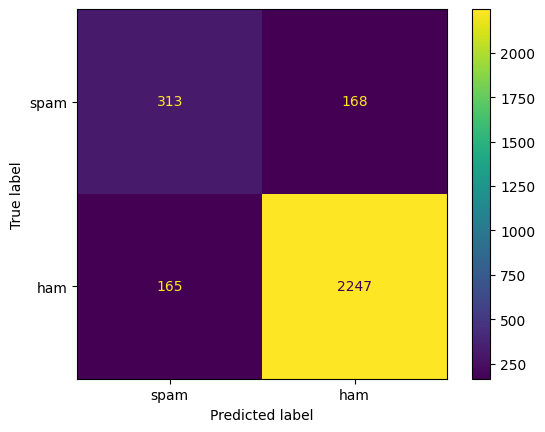

In [ ]:
#Confusion matrix for the test dataset
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels_list_test, predictions_list_test, labels = [1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["spam", "ham"])
disp.plot()
plt.savefig('confusionmatrix_for_dataset_test.png')
plt.show()